# Analyzing results of grid search

This notebook assumes you've downloaded data and run a grid search experiment
```sh
make update  # many hours
python mutrans.py --grid-search  # many hours
```

In [1]:
import math
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyrocov.util import pearson_correlation
from pyrocov.plotting import force_apart

matplotlib.rcParams["figure.dpi"] = 200

In [2]:
df = pd.read_csv("results/grid_search.tsv", sep="\t")
df = df.fillna("")
df

model_type                         cond_data  \
0                     reparam                                     
1                     reparam                  coef_scale=0.001   
2                     reparam                   coef_scale=0.01   
3                     reparam                    coef_scale=0.1   
4          reparam-asymmetric                                     
5          reparam-asymmetric                  coef_scale=0.001   
6          reparam-asymmetric                   coef_scale=0.01   
7          reparam-asymmetric                    coef_scale=0.1   
8   reparam-asymmetric-biased                                     
9   reparam-asymmetric-biased                  coef_scale=0.001   
10  reparam-asymmetric-biased  coef_scale=0.001,rate_scale=0.01   
11  reparam-asymmetric-biased   coef_scale=0.001,rate_scale=0.1   
12  reparam-asymmetric-biased                   coef_scale=0.01   
13  reparam-asymmetric-biased   coef_scale=0.01,rate_scale=0.01   
14  reparam-asymmetric-biased    coef_scale=0.01,rate_scale=0.1   
15  reparam-asymmetric-biased                   coef_scale=0.02   
16  reparam-asymmetric-biased                   coef_scale=0.05   
17  reparam-asymmetric-biased                    coef_scale=0.1   
18  reparam-asymmetric-biased    coef_scale=0.1,rate_scale=0.01   
19  reparam-asymmetric-biased     coef_scale=0.1,rate_scale=0.1   
20  reparam-asymmetric-biased                   rate_scale=0.01   
21  reparam-asymmetric-biased                    rate_scale=0.1   
22             reparam-biased                                     
23             reparam-biased                  coef_scale=0.001   
24             reparam-biased  coef_scale=0.001,rate_scale=0.01   
25             reparam-biased   coef_scale=0.001,rate_scale=0.1   
26             reparam-biased                   coef_scale=0.01   
27             reparam-biased   coef_scale=0.01,rate_scale=0.01   
28             reparam-biased    coef_scale=0.01,rate_scale=0.1   
29             reparam-biased                   coef_scale=0.02   
30             reparam-biased                   coef_scale=0.05   
31             reparam-biased                    coef_scale=0.1   
32             reparam-biased    coef_scale=0.1,rate_scale=0.01   
33             reparam-biased     coef_scale=0.1,rate_scale=0.1   
34             reparam-biased                   rate_scale=0.01   
35             reparam-biased                    rate_scale=0.1   

    England B.1.1.7 MAE  England B.1.1.7 RMSE  England MAE  England RMSE  \
0              0.010440              0.020694     0.000478      0.006354   
1              0.036778              0.066361     0.000599      0.006160   
2              0.013770              0.025629     0.000514      0.005384   
3              0.010365              0.019826     0.000483      0.005735   
4              0.010309              0.020405     0.000478      0.006368   
5              0.010788              0.021140     0.000486      0.005266   
6              0.009967              0.019752     0.000476      0.005290   
7              0.010385              0.020624     0.000475      0.005293   
8              0.008035              0.014352     0.000432      0.006472   
9              0.007083              0.013289     0.000430      0.006262   
10             0.009267              0.018058     0.000453      0.006393   
11             0.007294              0.013959     0.000430      0.005737   
12             0.007225              0.013937     0.000429      0.006163   
13             0.008767              0.017194     0.000451      0.005730   
14             0.007866              0.014105     0.000430      0.005737   
15             0.007223              0.013957     0.000430      0.006075   
16             0.007413              0.014717     0.000430      0.006479   
17             0.008009              0.014657     0.000431      0.006914   
18             0.008273              0.016361     0.000446      0.005869   
19             0.00

In [3]:
df.columns

Index(['model_type', 'cond_data', 'England B.1.1.7 MAE',
       'England B.1.1.7 RMSE', 'England MAE', 'England RMSE', 'MAE',
       'R(B.1.1.7)/R(A)', 'R(B.1.617.2)/R(A)', 'RMSE', 'lineage_corr',
       'lineage_mae', 'lineage_rmse', 'lineage_stdev', 'loss', 'mutation_corr',
       'mutation_mae', 'mutation_rmse', 'mutation_stddev', '|μ|/σ max',
       '|μ|/σ median', 'ΔlogR(S:D614G) mean', 'ΔlogR(S:D614G) std',
       'ΔlogR(S:E484K) mean', 'ΔlogR(S:E484K) std', 'ΔlogR(S:L452R) mean',
       'ΔlogR(S:L452R) std', 'ΔlogR(S:N501Y) mean', 'ΔlogR(S:N501Y) std'],
      dtype='object')

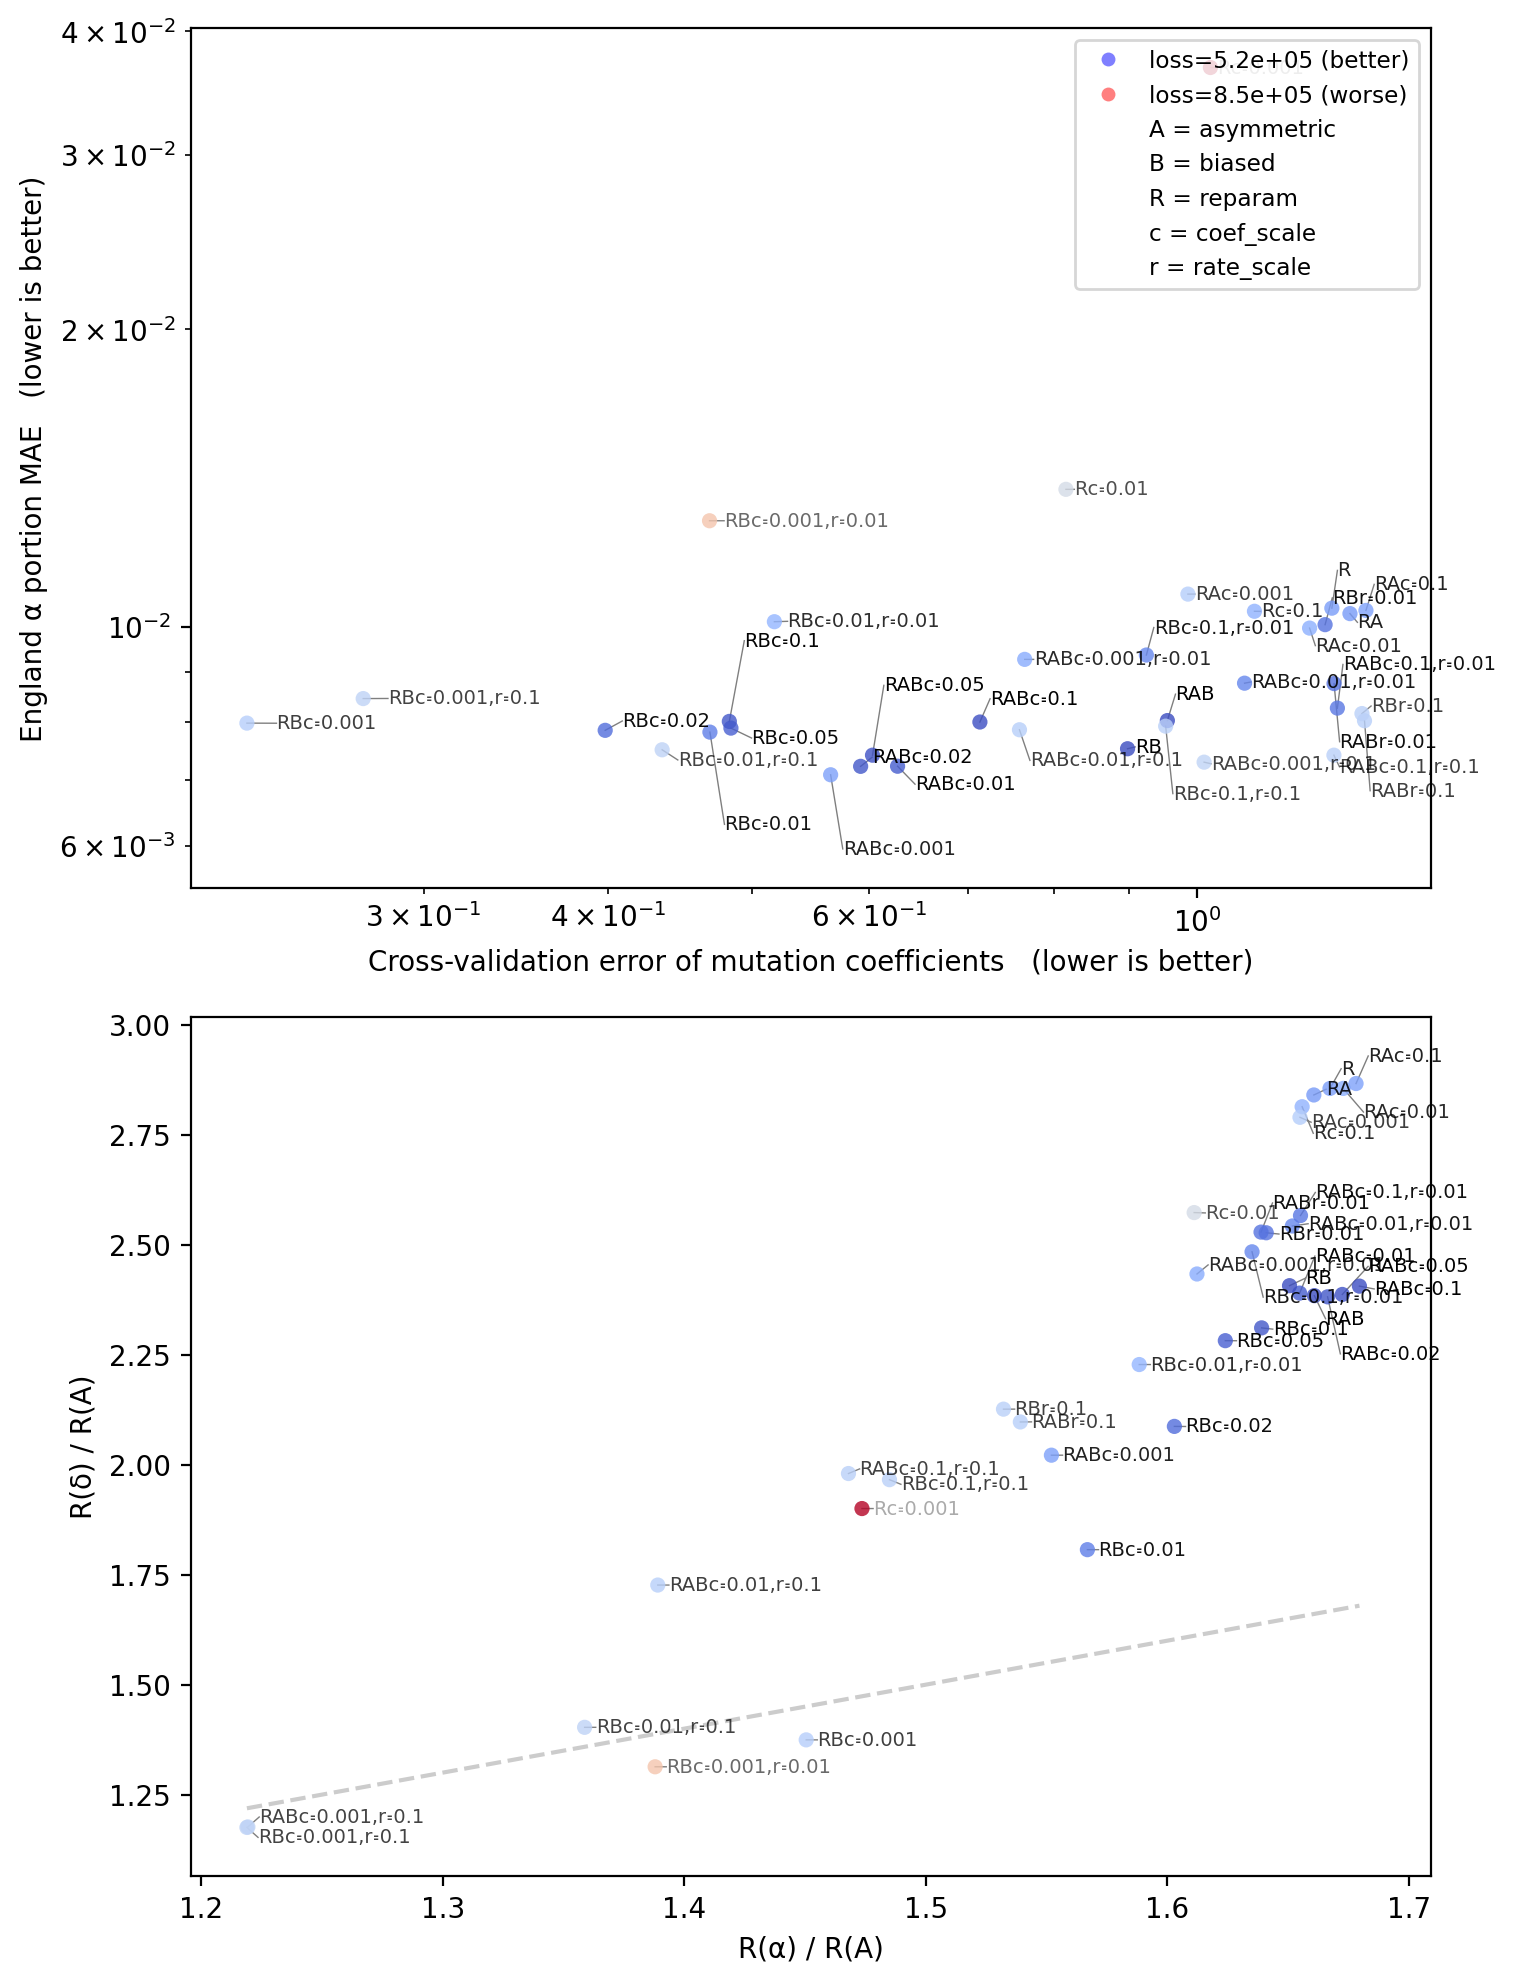

In [4]:
model_type = df["model_type"].to_list()
cond_data = df["cond_data"].to_list()
mutation_corr = df["mutation_corr"].to_numpy()
mutation_error = df["mutation_rmse"].to_numpy() / df["mutation_stddev"].to_numpy()
mae_pred = df["England B.1.1.7 MAE"].to_numpy()

loss = df["loss"].to_numpy()
min_loss, max_loss = loss.min(), loss.max()
assert (loss > 0).all(), "you'll need to switch to symlog or sth"
loss = np.log(loss)
loss -= loss.min()
loss /= loss.max()
R_alpha = df["R(B.1.1.7)/R(A)"].to_numpy()
R_delta = df["R(B.1.617.2)/R(A)"].to_numpy()

def plot_concordance(filenames=[], colorby="R"):
    legend = {}
    def abbreviate_param(match):
        k = match.group()[:-1]
        v = k[0].upper()
        legend[v] = k
        return v
    def abbreviate_sample(match):
        k = match.group()[:-1]
        v = k[0]
        legend[v] = k
        return v + "꞊"
    fig, axes = plt.subplots(2, figsize=(8, 12))
    for ax, X, Y, xlabel, ylabel in zip(
        axes, [mutation_error, R_alpha], [mae_pred, R_delta],
        [
            # "Pearson correlation of mutaitons",
            "Cross-validation error of mutation coefficients   (lower is better)",
            "R(α) / R(A)"],
        ["England α portion MAE   (lower is better)", "R(δ) / R(A)"]
    ):
        ax.scatter(X, Y, 30, loss, lw=0, alpha=0.8, cmap="coolwarm")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        X_, Y_ = force_apart(X, Y, stepsize=2)
        assert X_.dim() == 1
        X_X = []
        Y_Y = []
        for x_, x, y_, y in zip(X_, X, Y_, Y):
            X_X.extend([float(x_), float(x), None])
            Y_Y.extend([float(y_), float(y), None])
        ax.plot(X_X, Y_Y, "k-", lw=0.5, alpha=0.5, zorder=-10)
        for x, y, mt, cd, l in zip(X_, Y_, model_type, cond_data, loss):
            name = f"{mt}-{cd}"
            name = re.sub("[a-z_]+-", abbreviate_param, name)
            name = re.sub("[a-z_]+=", abbreviate_sample, name)
            name = name.replace("-", "")
            ax.text(x, y, name, fontsize=7, va="center", alpha=1 - 0.666 * l)
            
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].plot([], [], "bo", markeredgewidth=0, markersize=5, alpha=0.5,
                 label=f"loss={min_loss:0.2g} (better)")
    axes[0].plot([], [], "ro", markeredgewidth=0, markersize=5, alpha=0.5,
                 label=f"loss={max_loss:0.2g} (worse)")
    for k, v in sorted(legend.items()):
        axes[0].plot([], [], "wo", label=f"{k} = {v}")
    axes[0].legend(loc="upper right", fontsize="small")
    min_max = [max(X.min(), Y.min()), min(X.max(), Y.max())]
    axes[1].plot(min_max, min_max, "k--", alpha=0.2, zorder=-10)
    plt.subplots_adjust(hspace=0.15)
    for filename in filenames:
        plt.savefig(filename)
        
plot_concordance(["paper/grid_search.png"])

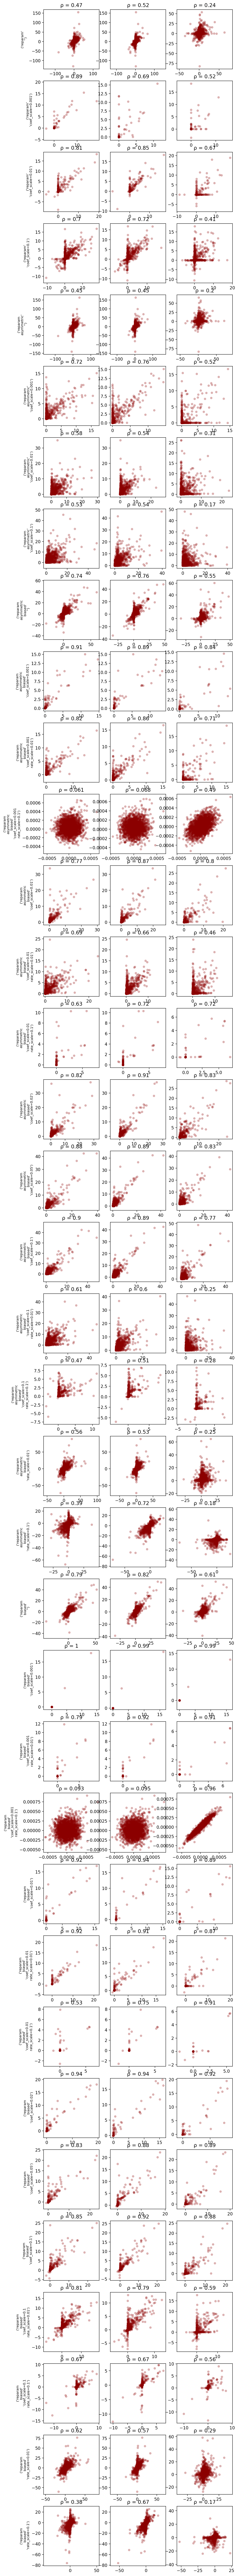

In [5]:
import torch
grid = torch.load("results/mutrans.grid.pt")

def plot_mutation_agreements(grid):
    fig, axes = plt.subplots(len(grid), 3, figsize=(8, 1 + 3 * len(grid)))
    for axe, (name, holdouts) in zip(axes, sorted(grid.items())):
        (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
        pairs = [
            [(name0, fit0), (name1, fit1)],
            [(name0, fit0), (name2, fit2)],
            [(name1, fit1), (name2, fit2)],
        ]
        means = [v["coef"] * 0.01 for v in holdouts.values()]
        x0 = min(mean.min().item() for mean in means)
        x1 = max(mean.max().item() for mean in means)
        lb = 1.05 * x0 - 0.05 * x1
        ub = 1.05 * x1 - 0.05 * x0
        axe[1].set_title(str(name))
        axe[0].set_ylabel(str(name).replace("-", "\n").replace(",", "\n"), fontsize=8)
        for ax, ((name1, fit1), (name2, fit2)) in zip(axe, pairs):
            mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
            means = []
            for fit in (fit1, fit2):
                m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
                idx = torch.tensor([m_to_i[m] for m in mutations])
                means.append(fit["coef"])
            ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
            ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
            ax.axis("equal")
            ax.set_title("ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
plot_mutation_agreements(grid)

## Debugging plotting code

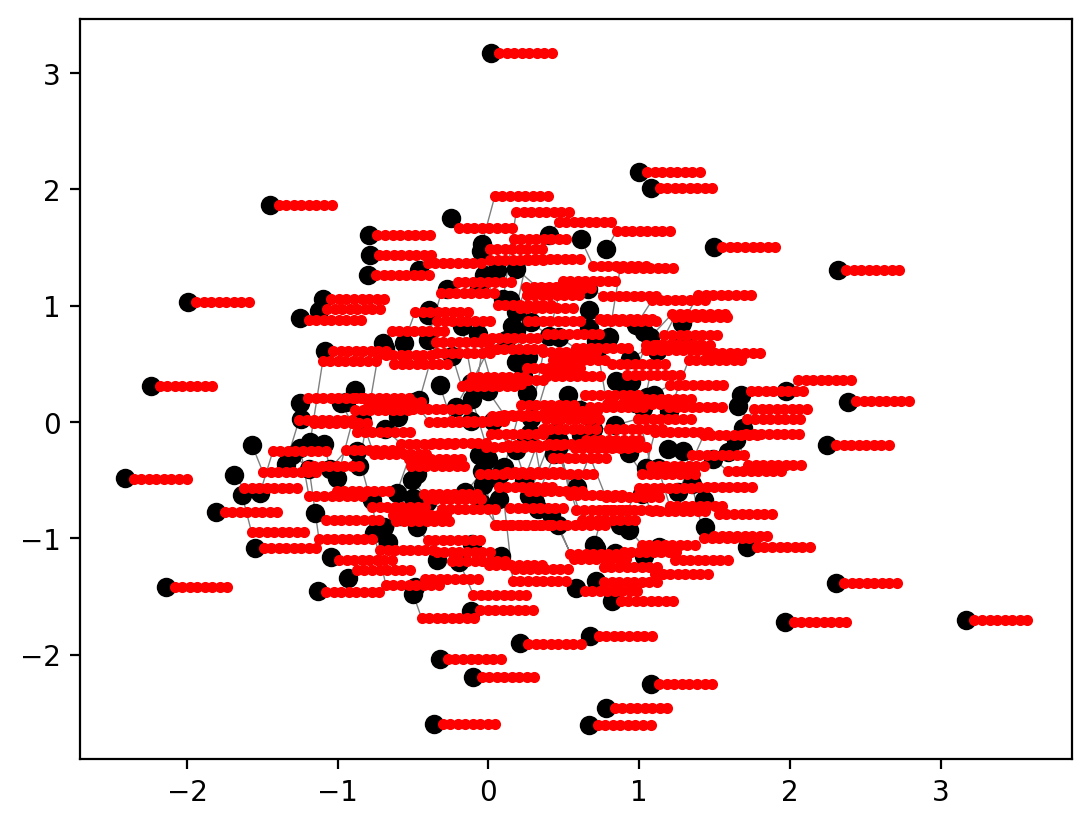

In [6]:
from pyrocov.plotting import force_apart
torch.manual_seed(1234567890)
X, Y = torch.randn(2, 200)
X_, Y_ = force_apart(X, Y)
plt.plot(X, Y, "ko")
for i in range(8):
    plt.plot(X_ + i / 20, Y_, "r.")
X_X = []
Y_Y = []
for x_, x, y_, y in zip(X_, X, Y_, Y):
    X_X.extend([float(x_), float(x), None])
    Y_Y.extend([float(y_), float(y), None])
plt.plot(X_X, Y_Y, "k-", lw=0.5, alpha=0.5, zorder=-10);